In [8]:
# ================= StegoShield++: Colab-ready with SQLite DB + DCT Watermarking =================
# Paste this whole cell into a NEW Google Colab notebook cell and run.

# 1) Installs
!apt-get install -y -qq tesseract-ocr > /dev/null
!pip install -q pillow numpy pytesseract matplotlib pandas scikit-learn ipywidgets plotly opencv-python

# 2) Imports & widget enable
from google.colab import output, files
output.enable_custom_widget_manager()

import os, io, math, json, random, shutil, hashlib, time, sqlite3, base64
from PIL import Image, ExifTags
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytesseract
import cv2
from sklearn.decomposition import PCA
import ipywidgets as w
from IPython.display import display, clear_output

# 3) Config (tweakable)
SCORE_BLOCK = 0.85
SCORE_QUARANTINE = 0.55
METADATA_SUSPICION_KEYS = ["comment", "UserComment", "XPComment", "ImageDescription"]
SUSPICIOUS_KEYWORDS = ["ignore", "download", "secret", "password", "execute", "run", "open", "leak", "exfiltrate"]

DB_PATH = "stegoshield.db"
os.makedirs("quarantine", exist_ok=True)
os.makedirs("watermarked", exist_ok=True)

# 4) Utility helpers
def file_sha256(path, block_size=65536):
    sha = hashlib.sha256()
    with open(path, "rb") as f:
        for block in iter(lambda: f.read(block_size), b""):
            sha.update(block)
    return sha.hexdigest()

def load_list(file_path):
    ext = file_path.lower().split(".")[-1]
    items = {}
    if ext == "csv":
        df = pd.read_csv(file_path)
        for _, row in df.iterrows():
            sha = str(row["sha256"]).strip().lower()
            reason = str(row.get("reason", "listed")).strip()
            items[sha] = reason
    elif ext == "json":
        with open(file_path, "r") as f:
            data = json.load(f)
            for sha, reason in data.items():
                items[str(sha).strip().lower()] = str(reason)
    return items

# 5) Initialize DB
def init_db(db_path=DB_PATH):
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()
    cur.execute("""
        CREATE TABLE IF NOT EXISTS analyses (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            timestamp TEXT,
            path TEXT,
            sha256 TEXT,
            decision TEXT,
            stego_score REAL,
            rdr_score REAL,
            lsb_entropy REAL,
            global_entropy REAL,
            blockiness REAL,
            ocr_texts TEXT,
            ocr_suspicious TEXT,
            quarantined_to TEXT,
            whitelist_reason TEXT,
            blacklist_reason TEXT,
            watermarked_path TEXT,
            watermark_message TEXT
        )
    """)
    conn.commit()
    return conn

def log_report(conn, report):
    cur = conn.cursor()
    cur.execute("""
        INSERT INTO analyses (
            timestamp, path, sha256, decision, stego_score, rdr_score,
            lsb_entropy, global_entropy, blockiness, ocr_texts, ocr_suspicious,
            quarantined_to, whitelist_reason, blacklist_reason, watermarked_path, watermark_message
        ) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)
    """, (
        time.strftime("%Y-%m-%d %H:%M:%S"), report.get("path"),
        report.get("sha256"), report.get("decision"),
        float(report.get("stego_score", 0.0)), float(report.get("rdr_score", 0.0)),
        float(report.get("lsb_entropy", 0.0)), float(report.get("global_entropy", 0.0)),
        float(report.get("blockiness", 0.0)),
        json.dumps(report.get("ocr_texts", [])),
        json.dumps(report.get("ocr_suspicious", [])),
        report.get("quarantined_to"), report.get("whitelist_reason"), report.get("blacklist_reason"),
        report.get("watermarked_path"), report.get("watermark_message")
    ))
    conn.commit()

# 6) Heuristic functions
def metadata_flags(img):
    flags = []
    try:
        exif = img.getexif()
        if exif:
            for tag_id, value in exif.items():
                tag = ExifTags.TAGS.get(tag_id, tag_id)
                if tag in METADATA_SUSPICION_KEYS:
                    flags.append(f"meta_field:{tag}")
                if isinstance(value, (bytes, bytearray)):
                    flags.append(f"meta_raw_bytes:{tag}")
                if isinstance(value, str) and len(value) > 512:
                    flags.append(f"meta_long:{tag}")
    except Exception:
        pass
    try:
        info = img.info or {}
        for k, v in info.items():
            if k.lower() in METADATA_SUSPICION_KEYS or (isinstance(v, str) and len(v) > 512):
                flags.append(f"png_info:{k}")
    except Exception:
        pass
    return list(set(flags))

def shannon_entropy(arr):
    hist = np.bincount(arr.flatten(), minlength=256).astype(float)
    probs = hist / (hist.sum() + 1e-12)
    probs = probs[probs > 0]
    return -np.sum(probs * np.log2(probs + 1e-12))

def lsb_entropy_score(img):
    g = np.array(img.convert("L"), dtype=np.uint8)
    lsb = (g & 1).flatten()
    p1 = lsb.mean()
    if p1 in (0.0, 1.0):
        return 0.0
    return - (p1 * math.log2(p1) + (1 - p1) * math.log2(1 - p1))

def jpeg_blockiness_score(img):
    arr = np.array(img.convert("L"), dtype=np.float32)
    h, w = arr.shape
    if h < 16 or w < 16:
        return 0.0
    diffs = []
    for x in range(8, w, 8):
        diffs.append(np.mean(np.abs(arr[:, x] - arr[:, x-1])))
    for y in range(8, h, 8):
        diffs.append(np.mean(np.abs(arr[y, :] - arr[y-1, :])))
    if not diffs:
        return 0.0
    norm = np.mean(np.abs(arr - arr.mean())) + 1e-6
    return float(np.mean(diffs) / norm)

# 7) OCR + RDR
def ocr_with_boxes(img):
    data = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT)
    texts, boxes, suspicious = [], [], []
    for i in range(len(data['text'])):
        txt = str(data['text'][i]).strip()
        if txt:
            x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
            boxes.append((x, y, w, h, txt))
            texts.append(txt)
            if any(k in txt.lower() for k in SUSPICIOUS_KEYWORDS):
                suspicious.append((x, y, w, h, txt))
    return texts, boxes, suspicious

def ocr_random_resamples(img, num_resamples=5):
    ocr_texts = []
    for _ in range(num_resamples):
        scale = random.uniform(0.6, 1.3)
        method = random.choice([Image.BICUBIC, Image.BILINEAR, Image.NEAREST])
        new_w = max(32, int(img.width * scale))
        new_h = max(32, int(img.height * scale))
        rendered = img.resize((new_w, new_h), method)
        if rendered.width > 100 and rendered.height > 100 and random.random() < 0.5:
            crop_w = int(rendered.width * random.uniform(0.6, 0.95))
            crop_h = int(rendered.height * random.uniform(0.6, 0.95))
            cx = random.randint(0, rendered.width - crop_w)
            cy = random.randint(0, rendered.height - crop_h)
            rendered = rendered.crop((cx, cy, cx + crop_w, cy + crop_h))
        text = pytesseract.image_to_string(rendered).strip()
        if text:
            ocr_texts.append(text)
    return ocr_texts

def rdr_inconsistency_score(img, num_resamples=5):
    texts = ocr_random_resamples(img, num_resamples=num_resamples)
    if not texts:
        return 0.0, []
    count_susp = sum(1 for t in texts if any(k in t.lower() for k in SUSPICIOUS_KEYWORDS))
    frac = count_susp / max(1, len(texts))
    if count_susp > 0 and frac < 0.7:
        inconsistency = 0.5 + (0.5 * (1 - frac))
    elif count_susp > 0:
        inconsistency = 0.4 * frac
    else:
        inconsistency = 0.0
    suspicious_texts = [t for t in texts if any(k in t.lower() for k in SUSPICIOUS_KEYWORDS)]
    return float(inconsistency), suspicious_texts

# 8) Frequency purger (low-pass DCT demo)
def enhanced_frequency_purger(img):
    arr = np.array(img.convert("L"), dtype=np.float32)
    # Use OpenCV DCT on float32; pad to multiple of 8 for stability
    h, w = arr.shape
    ph = (8 - (h % 8)) % 8
    pw = (8 - (w % 8)) % 8
    arr_p = np.pad(arr, ((0,ph),(0,pw)), mode='reflect')
    arr_p = arr_p.astype(np.float32)
    # blockwise DCT low-pass: zero out high freq in each 8x8 block
    bh, bw = arr_p.shape[0] // 8, arr_p.shape[1] // 8
    recon = np.zeros_like(arr_p)
    for i in range(bh):
        for j in range(bw):
            block = arr_p[i*8:(i+1)*8, j*8:(j+1)*8]
            d = cv2.dct(block)
            # keep low-frequency top-left 4x4
            mask = np.zeros_like(d)
            mask[:4,:4] = 1.0
            d_filtered = d * mask
            recon[i*8:(i+1)*8, j*8:(j+1)*8] = cv2.idct(d_filtered)
    recon = recon[:h, :w]
    recon = np.clip(recon, 0, 255).astype(np.uint8)
    return Image.fromarray(recon)

# 9) DCT-based watermark embedder (demo immunization)
def embed_watermark_dct(host_path, out_path, message, alpha=5):
    """
    Embed a short message bits into low-frequency DCT coeffs in Y channel (YCrCb).
    - host_path: input image path
    - out_path: output watermarked path
    - message: short ASCII string (keep small)
    - alpha: embedding strength (small ints)
    """
    img = cv2.imread(host_path)
    if img is None:
        raise ValueError("Cannot read host image")
    # convert to YCrCb
    ycbcr = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb).astype(np.float32)
    y = ycbcr[:,:,0]
    h, w = y.shape
    # pad to multiples of 8
    ph = (8 - (h % 8)) % 8
    pw = (8 - (w % 8)) % 8
    y_p = np.pad(y, ((0,ph),(0,pw)), mode='reflect')
    bh, bw = y_p.shape[0] // 8, y_p.shape[1] // 8
    # prepare message bits
    msg_bytes = message.encode('utf-8')
    msg_b64 = base64.b64encode(msg_bytes).decode('ascii')  # base64 safe
    bits = ''.join(format(b, '08b') for b in msg_b64.encode('ascii'))
    max_bits = bh * bw  # one bit per block (use DC or (1,0) coefficient)
    bits = bits[:max_bits]
    if len(bits) == 0:
        raise ValueError("Message empty or host too small")
    bit_idx = 0
    for i in range(bh):
        for j in range(bw):
            if bit_idx >= len(bits): break
            block = y_p[i*8:(i+1)*8, j*8:(j+1)*8]
            d = cv2.dct(block)
            # choose coefficient (1,0) (low-frequency) to modify
            r, c = 1, 0
            bit = int(bits[bit_idx])
            # embed by adding +/- alpha to coefficient parity (demo scheme)
            # make coefficient even/odd according to bit
            coeff = d[r,c]
            coeff_int = int(np.round(coeff))
            target = coeff_int
            if (coeff_int % 2) != bit:
                # adjust by alpha in sign of coeff
                if coeff_int >= 0:
                    coeff += alpha
                else:
                    coeff -= alpha
            d[r,c] = coeff
            y_p[i*8:(i+1)*8, j*8:(j+1)*8] = cv2.idct(d)
            bit_idx += 1
        if bit_idx >= len(bits): break
    # crop back
    y_wm = y_p[:h, :w]
    ycbcr[:,:,0] = y_wm
    out_bgr = cv2.cvtColor(ycbcr.astype(np.uint8), cv2.COLOR_YCrCb2BGR)
    cv2.imwrite(out_path, out_bgr)
    return out_path, msg_b64  # return base64'd message stored

# 10) PCA purger PoC (patch-based)
def image_patch_embeddings(img, patch_size=16):
    g = np.array(img.convert("L"), dtype=np.float32)
    h, w = g.shape
    ph = (patch_size - (h % patch_size)) % patch_size
    pw = (patch_size - (w % patch_size)) % patch_size
    if ph > 0 or pw > 0:
        g = np.pad(g, ((0, ph), (0, pw)), mode='reflect')
    gh = g.shape[0] // patch_size
    gw = g.shape[1] // patch_size
    patches = g.reshape(gh, patch_size, gw, patch_size).swapaxes(1,2).reshape(-1, patch_size*patch_size)
    return patches, gh, gw

def purger_pca_project_embedding(img, n_components=1, patch_size=16):
    patches, gh, gw = image_patch_embeddings(img, patch_size=patch_size)
    if patches.shape[0] <= n_components or patches.shape[1] <= n_components or n_components <= 0:
        return img
    patches_norm = (patches - patches.mean(axis=1, keepdims=True)) / (patches.std(axis=1, keepdims=True) + 1e-6)
    pca = PCA(n_components=n_components)
    try:
        pca.fit(patches_norm)
    except Exception:
        return img
    comps = pca.components_
    proj = patches_norm.copy()
    for c in comps:
        proj = proj - np.outer(np.dot(proj, c), c)
    recon = proj.reshape(gh, gw, patch_size, patch_size).swapaxes(1,2).reshape(gh*patch_size, gw*patch_size)
    recon = recon - recon.min()
    recon = recon / (recon.max() + 1e-6) * 255.0
    recon = recon.astype(np.uint8)
    return Image.fromarray(recon)

# 11) Main analyze function (integrated, logs to DB, optionally watermarks)
def analyze_image(path, HASH_WHITELIST, HASH_BLACKLIST, conn, quarantine_dir="quarantine",
                  apply_purger_ncomp=0, watermark_enabled=False, watermark_msg="stegoshield-demo"):
    img = Image.open(path).convert('RGB')
    res = {"path": path, "sha256": file_sha256(path)}
    res["whitelist_reason"] = None
    res["blacklist_reason"] = None
    res["quarantined_to"] = None
    res["watermarked_path"] = None
    res["watermark_message"] = None

    if res["sha256"] in HASH_WHITELIST:
        res["decision"] = "ALLOW"
        res["whitelist_reason"] = HASH_WHITELIST[res["sha256"]]
        log_report(conn, res)
        return res
    if res["sha256"] in HASH_BLACKLIST:
        res["decision"] = "BLOCK"
        res["blacklist_reason"] = HASH_BLACKLIST[res["sha256"]]
        dest = os.path.join(quarantine_dir, os.path.basename(path))
        if os.path.exists(path):
            shutil.move(path, dest)
            res["quarantined_to"] = dest
        log_report(conn, res)
        return res

    # heuristics
    flags = metadata_flags(img)
    res["metadata_flags"] = flags
    res["lsb_entropy"] = lsb_entropy_score(img)
    res["global_entropy"] = shannon_entropy(np.array(img.convert("L")))
    res["blockiness"] = jpeg_blockiness_score(img)

    texts, boxes, suspicious_boxes = ocr_with_boxes(img)
    res["ocr_texts"] = texts
    res["ocr_suspicious"] = [t[-1] for t in suspicious_boxes]

    rdr_score, rdr_sus = rdr_inconsistency_score(img)
    res["rdr_score"] = rdr_score
    res["rdr_examples"] = rdr_sus

    score = (0.35*res["lsb_entropy"] + 0.15*(res["global_entropy"]/8.0) +
             0.25*res["blockiness"] + (0.6 if flags else 0.0))
    res["stego_score"] = float(max(0.0, min(1.0, score)))

    decision = "ALLOW"
    if res["stego_score"] >= SCORE_BLOCK:
        decision = "BLOCK"
    elif res["stego_score"] >= SCORE_QUARANTINE:
        decision = "SUSPICIOUS"
    if rdr_score >= 0.5:
        if decision == "ALLOW":
            decision = "SUSPICIOUS"
        else:
            decision = "BLOCK"
    if suspicious_boxes and decision != "BLOCK":
        decision = "SUSPICIOUS"

    # optional purger
    if apply_purger_ncomp and decision in ["SUSPICIOUS", "BLOCK"]:
        purged_img = purger_pca_project_embedding(img, n_components=apply_purger_ncomp)
        try:
            ptexts = [t.strip() for t in pytesseract.image_to_string(purged_img).splitlines() if t.strip()]
        except Exception:
            ptexts = []
        res["purger_applied"] = True
        res["purger_ncomp"] = apply_purger_ncomp
        res["purger_ocr_after"] = ptexts
        if not any(any(k in t.lower() for k in SUSPICIOUS_KEYWORDS) for t in ptexts):
            if decision == "BLOCK": decision = "SUSPICIOUS"
            elif decision == "SUSPICIOUS": decision = "ALLOW"

    res["decision"] = decision

    # quarantine if needed
    if decision in ["SUSPICIOUS", "BLOCK"]:
        os.makedirs(quarantine_dir, exist_ok=True)
        dest = os.path.join(quarantine_dir, os.path.basename(path))
        if os.path.exists(path):
            shutil.move(path, dest)
        res["quarantined_to"] = dest

    # watermark safe images if enabled and allowed
    if watermark_enabled and decision == "ALLOW":
        try:
            outp = os.path.join("watermarked", os.path.basename(path))
            wm_path, msg_b64 = embed_watermark_dct(path, outp, watermark_msg, alpha=4)
            res["watermarked_path"] = wm_path
            res["watermark_message"] = msg_b64
        except Exception as e:
            res["watermark_error"] = str(e)

    # log and return
    log_report(conn, res)
    return res

# 12) Workflow: DB init, upload lists, choose options, upload images
conn = init_db(DB_PATH)

print("Upload blacklist CSV/JSON (optional) or cancel:")
uploaded = files.upload()
HASH_BLACKLIST = {}
if uploaded:
    try:
        HASH_BLACKLIST = load_list(list(uploaded.keys())[0])
    except Exception as e:
        print("Failed to load blacklist:", e)
print("Blacklist count:", len(HASH_BLACKLIST))

print("Upload whitelist CSV/JSON (optional) or cancel:")
uploaded = files.upload()
HASH_WHITELIST = {}
if uploaded:
    try:
        HASH_WHITELIST = load_list(list(uploaded.keys())[0])
    except Exception as e:
        print("Failed to load whitelist:", e)
print("Whitelist count:", len(HASH_WHITELIST))

# options
try:
    purger_ncomp = int(input("Purger PCA components to remove (0 to skip, 1 or 2 for demo): ") or "0")
except Exception:
    purger_ncomp = 0
wm_choice = input("Enable automatic watermarking for ALLOW images? (y/N): ").strip().lower()
watermark_enabled = (wm_choice == 'y')
if watermark_enabled:
    watermark_msg = input("Enter watermark message (short text) [default 'stegoshield-demo']: ").strip() or "stegoshield-demo"
else:
    watermark_msg = ""

print("Now upload images to analyze (one or more).")
uploaded = files.upload()
reports = []
start = time.time()
for fname in list(uploaded.keys()):
    print("Processing:", fname)
    try:
        r = analyze_image(fname, HASH_WHITELIST, HASH_BLACKLIST, conn,
                          quarantine_dir="quarantine", apply_purger_ncomp=purger_ncomp,
                          watermark_enabled=watermark_enabled, watermark_msg=watermark_msg)
    except Exception as e:
        r = {"path": fname, "error": str(e)}
        print("Error:", e)
    reports.append(r)
    print(json.dumps(r, indent=2))
end = time.time()
print(f"Processed {len(reports)} images in {end-start:.1f}s")

# 13) Save CSV & quarantine, watermarked zip
df = pd.DataFrame(reports)
csv_path = "image_analysis_report.csv"
df.to_csv(csv_path, index=False)
print("Saved report:", csv_path)
files.download(csv_path)

if os.path.exists("quarantine"):
    shutil.make_archive("quarantine_images", 'zip', "quarantine")
    files.download("quarantine_images.zip")
if os.path.exists("watermarked"):
    shutil.make_archive("watermarked_images", 'zip', "watermarked")
    files.download("watermarked_images.zip")

# 14) Simple interactive review (Select + preview)
for col in ['ocr_texts','ocr_suspicious','purger_ocr_after']:
    if col in df.columns:
        def _to_list(x):
            if isinstance(x, list): return x
            if pd.isna(x): return []
            s = str(x)
            try: return json.loads(s)
            except:
                try: return ast.literal_eval(s)
                except: return [s]
        df[col] = df[col].apply(_to_list)

opts = []
for _, r in df.iterrows():
    display_path = r.get('quarantined_to') if isinstance(r.get('quarantined_to'), str) and r.get('quarantined_to') else r['path']
    label = f"{r.get('decision','?')} | {os.path.basename(display_path)}"
    opts.append((label, display_path))

if not opts:
    print("No images to preview.")
else:
    sel = w.Select(options=opts, rows=8, description='Images:')
    out = w.Output()
    display(w.HBox([sel, out]))
    def draw_preview(change=None):
        path = sel.value
        with out:
            clear_output(wait=True)
            if not path or not os.path.exists(path):
                print("File not found:", path)
                return
            im = Image.open(path).convert('RGB')
            texts, boxes, suspicious = ocr_with_boxes(im)
            fig, ax = plt.subplots(figsize=(8,6))
            ax.imshow(im)
            for (x,y,w_,h_,txt) in boxes:
                color = "red" if any(k in txt.lower() for k in SUSPICIOUS_KEYWORDS) else "lime"
                rect = plt.Rectangle((x,y), w_, h_, fill=False, edgecolor=color, linewidth=2)
                ax.add_patch(rect)
            ax.set_title(os.path.basename(path))
            plt.axis('off')
            plt.show()
    sel.observe(draw_preview, names='value')
    sel.value = opts[0][1]
    draw_preview()

print("Done. You can query the SQLite DB 'stegoshield.db' for historical records.")
# ==============================================================================================


Upload blacklist CSV/JSON (optional) or cancel:


Saving good_logs (1).csv to good_logs (1) (2).csv
Failed to load blacklist: 'sha256'
Blacklist count: 0
Upload whitelist CSV/JSON (optional) or cancel:


Saving bad_logs (1).csv to bad_logs (1) (2).csv
Failed to load whitelist: 'sha256'
Whitelist count: 0
Purger PCA components to remove (0 to skip, 1 or 2 for demo): 0
Enable automatic watermarking for ALLOW images? (y/N): N
Now upload images to analyze (one or more).


Saving SACHINGPU.png to SACHINGPU.png
Processing: SACHINGPU.png
{
  "path": "SACHINGPU.png",
  "sha256": "ed3a52be885ab73f9ae825981a02677e3b01fd5aa1344f8724c13a548b73cbc8",
  "whitelist_reason": null,
  "blacklist_reason": null,
  "quarantined_to": null,
  "watermarked_path": null,
  "watermark_message": null,
  "metadata_flags": [],
  "lsb_entropy": 0.8388239164982898,
  "global_entropy": 3.3991898073807674,
  "blockiness": 0.10487581044435501,
  "ocr_texts": [
    "Se",
    "sd",
    "CERTIFICATE",
    "OF",
    "PARTICIPATION",
    "This",
    "is",
    "to",
    "certify",
    "that",
    "_",
    "SACHINT",
    "has",
    "participated",
    "in",
    "the",
    "GPU",
    "Programming",
    "workshop",
    "conducted",
    "during",
    "FOSSMeet'25",
    "from",
    "March",
    "14th",
    "to",
    "16th,",
    "2025",
    "at",
    "National",
    "institute",
    "of",
    "Technology",
    "Calicut.",
    "Paitin"
  ],
  "ocr_suspicious": [],
  "rdr_score": 0.0,
  "rdr_exam

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Done. You can query the SQLite DB 'stegoshield.db' for historical records.


Upload ground truth labels CSV with format: path, label (ALLOW/SUSPICIOUS/BLOCK)


Saving merged_logs (1).csv to merged_logs (1) (2).csv

=== Classification Report ===
              precision    recall  f1-score   support

       ALLOW       0.00      0.00      0.00       0.0
  SUSPICIOUS       0.00      0.00      0.00       0.0
       BLOCK       0.00      0.00      0.00       0.0

    accuracy                           0.00       0.0
   macro avg       0.00      0.00      0.00       0.0
weighted avg       0.00      0.00      0.00       0.0


=== Confusion Matrix ===


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

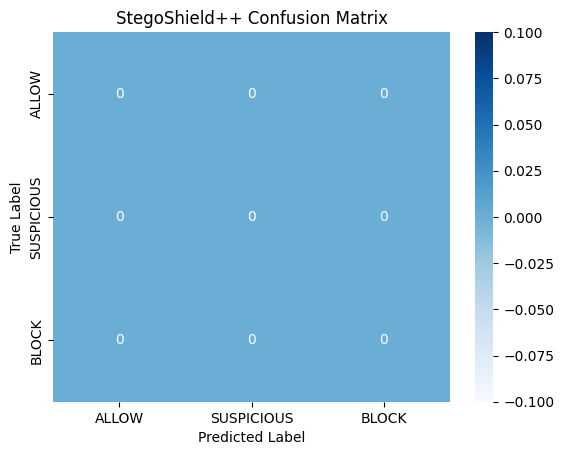

In [6]:
# ================= Cell 2: Evaluation Metrics for StegoShield++ =================

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

print("Upload ground truth labels CSV with format: path, label (ALLOW/SUSPICIOUS/BLOCK)")
uploaded = files.upload()
label_csv = list(uploaded.keys())[0]
gt_df = pd.read_csv(label_csv)

# Normalize paths to just filenames for matching
# Handle potential NaN values in the 'path' column
gt_df['filename'] = gt_df['path'].fillna('').apply(lambda x: os.path.basename(x))

# Merge predictions (df from Cell 1) with ground truth
if 'filename' not in df.columns:
    df['filename'] = df['path'].apply(lambda x: os.path.basename(str(x)))

merged = pd.merge(gt_df, df, on="filename", suffixes=("_true", "_pred"))

y_true = merged['label'].values
y_pred = merged['decision'].values

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, labels=["ALLOW","SUSPICIOUS","BLOCK"]))

print("\n=== Confusion Matrix ===")
cm = confusion_matrix(y_true, y_pred, labels=["ALLOW","SUSPICIOUS","BLOCK"])
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["ALLOW","SUSPICIOUS","BLOCK"],
            yticklabels=["ALLOW","SUSPICIOUS","BLOCK"],
            cmap="Blues")
plt.title("StegoShield++ Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [7]:
print("Ground Truth DataFrame (gt_df) head:")
display(gt_df.head())
print("\nGround Truth DataFrame columns:")
print(gt_df.columns)

print("\nAnalysis Results DataFrame (df) head:")
display(df.head())
print("\nAnalysis Results DataFrame columns:")
print(df.columns)

Ground Truth DataFrame (gt_df) head:


,service,event,endpoint,method,user_id,ip,status_code,latency_ms,timestamp,user,...,file_count,time_window_min,exception_type,stack_trace,secret_name,detected_mime,attempt_count,path,locations,time_diff_sec
0,api-auth,password_reset_request,NaN,NaN,NaN,NaN,NaN,NaN,2025-09-02 11:10:05,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ci-cd-pipeline,code_deployment,NaN,NaN,NaN,NaN,NaN,NaN,2025-09-02 10:19:21,jane.doe,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,app-server,checkout_request,/api/v1/checkout,NaN,NaN,NaN,200.0,NaN,2025-09-02 15:14:22,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,app-server,checkout_request,/api/v1/checkout,NaN,NaN,NaN,200.0,NaN,2025-09-02 13:14:45,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,app-server,checkout_request,/api/v1/checkout,NaN,NaN,NaN,200.0,NaN,2025-09-02 11:12:43,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Ground Truth DataFrame columns:
Index(['service', 'event', 'endpoint', 'method', 'user_id', 'ip',
       'status_code', 'latency_ms', 'timestamp', 'user', 'session_id',
       'commit_hash', 'filename', 'mime_type', 'email', 'query', 'duration_ms',
       'level', 'label', 'message', 'reason', 'key', 'table', 'rows_count',
       'action', 'file_count', 'time_window_min', 'exception_type',
       'stack_trace', 'secret_name', 'detected_mime', 'attempt_count', 'path',
       'locations', 'time_diff_sec'],
      dtype='object')

Analysis Results DataFrame (df) head:


,path,sha256,whitelist_reason,blacklist_reason,quarantined_to,watermarked_path,watermark_message,metadata_flags,lsb_entropy,global_entropy,blockiness,ocr_texts,ocr_suspicious,rdr_score,rdr_examples,stego_score,decision,filename
0,image (2).png,c2e494ed6f80982dcafb44fbeec9c0d52ce2cf91aa0595...,None,None,None,None,None,[],0.999996,3.971156,0.314654,"[SURAKSHASat, -Autonomous, Power, Resilience, ...",[],0.0,[],0.503121,ALLOW,image (2).png



Analysis Results DataFrame columns:
Index(['path', 'sha256', 'whitelist_reason', 'blacklist_reason',
       'quarantined_to', 'watermarked_path', 'watermark_message',
       'metadata_flags', 'lsb_entropy', 'global_entropy', 'blockiness',
       'ocr_texts', 'ocr_suspicious', 'rdr_score', 'rdr_examples',
       'stego_score', 'decision', 'filename'],
      dtype='object')
